### Demo to perform enrichment on GO terms

Here we can see the code to generate the enrichment with go terms

In [1]:
import json
import gzip
import copy
import re
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import fisher_exact
from wordcloud import WordCloud

### 1. Define basic datasets

After defining the GO datasets we are ready to create the other dataset (architetures, proteins and string).

In [2]:
RESULTS_PATH = 'data/results/ensemble.tsv' #Original dataset
GO_PATH = 'data/go/go.csv' # Dataset of all human protein with primal key (uniprot_id, go_id)

#Dataset of 'original' proteins with primal key (uniprot_id, go_id)
GO_ORIGINAL_PATH = OUT_PATH_GO_ORIGINAL = 'data/go/go_original.csv' 

In [3]:
# Load the results to see which uniprot proteins passed the model
original_dataset = pd.read_csv(RESULTS_PATH, sep='\t')
# Slice the GO dataset using the entry_ac of the protein that passed the model 
go_dataset = pd.read_csv(GO_PATH, sep='\t', dtype=str)
go_original_dataset = go_dataset[go_dataset.entry_ac.isin(original_dataset.entry_ac)]
# Save the model
go_original_dataset.to_csv(OUT_PATH_GO_ORIGINAL, sep='\t')
go_original_dataset.head()

,entry_ac,go_id,go_descr
5008,Q9BTA9,0016607,nuclear speck
5009,Q9BTA9,0005654,nucleoplasm
5010,Q9BTA9,0005634,nucleus
5011,Q9BTA9,0005681,spliceosomal complex
5012,Q9BTA9,0003682,chromatin binding


### 2. Define PDB datasets

Here we create the original and background datasets for PDB based on the GO dataset created in 1. <br>

It requires the file that maps a PDB_ID to a UNIPROT_ID

In [4]:
### REQUIRES
RESULTS_PATH = 'data/results/ensemble.tsv'
GO_PATH = 'data/go/go.csv'
MAPPING_FILE_PATH = 'data/pdb_data/pdb_chain_uniprot.tsv'
HUMAN_UNIPROT_PATH = 'data/human.csv'

OUT_BACKGROUND_PDB_PATH = 'data/pdb_data/pdb_background_go.csv'
OUT_TARGET_PDB_DATASETS_PATH = 'data/pdb_data/pdb_target_go.csv'

In [5]:
"""
Functions that create the datasets (target and background) for PDB network
"""
def pdb_target_dataset(original_dataset_path, go_dataset_path,
                       mapping_dataset_path, human_dataset_path,
                       col_name_entry = 'entry_ac', col_name_pdb = 'pdb_ids'):

    """
    1. original_dataset_path: the path of the target dataset, a.k.a the dataset of protein tha passed our model
    2. go_dataset_path: the path of the full go dataset (entry_ac, go_id)
    3. mapping_dataset_path: the path of the file mapping from pdb to uniprot
    4. human_dataset_path: the path of the full human dataset
    5. col_name_entry: the name of the column containing the proteins uniprot id
    6. col_name_pdb: the name of the column containing the proteins pdb id
    """

    ### 1. Load the mapping
    mapping_df = pd.read_table(mapping_dataset_path, header=1)
    mapping_df.columns = [col.lower() for col in mapping_df.columns]
    ### 2. Load the original dataset
    original_df = pd.read_table(original_dataset_path)
    ### 3. Load the go dataset
    background_df = pd.read_table(go_dataset_path, dtype={'entry_ac': str, 'go_id': str, 'go_descr': str})
    ### 4. Load the human dataset
    human_df = pd.read_table(human_dataset_path)
    # 4.1 Take out the entry_ac that have a pdb_id
    protein_with_pdb = human_df.entry_ac[human_df[col_name_pdb].isna() == False]
    # 4.2 Take out from  the background dataset the protein without a pdb
    background_df = background_df[background_df[col_name_entry].isin(protein_with_pdb)]
    ### 5. Get all original proteins with a pdb and get all the other proteins which shares the same pdb
    # 5.1. Get a dataset with key (uniprot_id, pdb_id)
    values = []
    for n in range(original_df.shape[1]):
        key = original_df.loc[n, col_name_entry]
        value = original_df.loc[n, col_name_pdb]
        if type(value) == str:
            pdb_ids = value.split(';')[:-1]
            for ids in pdb_ids:
                values.append([key, ids.lower()])
    pdb_original = pd.DataFrame(values, columns=[col_name_entry, col_name_pdb])
    # 5.2 Merge the new dataset with the mapping df to get all the proteins with that pdb id
    target_dataset = pd.merge(pdb_original, mapping_df, left_on=col_name_pdb, right_on='pdb', how='left')
    ### 6. Get the GO of every pdb_in our target_dataset
    target_dataset = background_df[background_df[col_name_entry].isin(target_dataset['sp_primary'])]
    ###

    return target_dataset, background_df

In [6]:
target_pdb, background_pdb = pdb_target_dataset(original_dataset_path=RESULTS_PATH, 
                                                go_dataset_path=GO_PATH, 
                                                mapping_dataset_path=MAPPING_FILE_PATH, 
                                                human_dataset_path=HUMAN_UNIPROT_PATH)

target_pdb.to_csv(OUT_TARGET_PDB_DATASETS_PATH, sep='\t')
background_pdb.to_csv(OUT_BACKGROUND_PDB_PATH, sep='\t')
target_pdb.head()

,entry_ac,go_id,go_descr
8713,Q9NZC7,0005737,cytoplasm
8714,Q9NZC7,0005829,cytosol
8715,Q9NZC7,0005794,Golgi apparatus
8716,Q9NZC7,0005739,mitochondrion
8717,Q9NZC7,0005654,nucleoplasm


### 3. Architecture Datasets

Here we create all the datasets divided by architectures

In [7]:
## REQUIRES 
HUMAN_UNIPROT_PATH = 'data/human.csv'
RESULTS_PATH = 'data/results/ensemble.tsv'
GO_PATH = 'data/go/go.csv'

OUT_BACKGROUND_ARCHITECTURE_PATH = 'data/architecture2/go_architectures/architecture_background.csv'
OUT_TARGET_ARCHITECTURE_DATASETS_PATH = 'data/architecture2/go_architectures/'

#### 3.1 We first create the background dataset (the original one) 

In [8]:
go_dataset = pd.read_csv(GO_PATH, sep='\t', dtype=str)
human_dataset = pd.read_csv(HUMAN_UNIPROT_PATH, sep='\t')
original_dataset = pd.read_csv(RESULTS_PATH, sep='\t')

# Select sets of domain families
architectures = [set(x.split(';')[:-1]) for x in original_dataset["pfam_ids"][original_dataset['pfam_ids'].isna() == False]]
# Sort architecture sets and convert them in strings
architectures = [';'.join(sorted(list(x))) for x in architectures]

# Create a new dataframe mapping each protein to its domain architecture
background_architecture = pd.DataFrame(list(zip(original_dataset['entry_ac'], architectures)), 
                                       columns=('entry_ac', 'architecture'), dtype=str)
# Save the dataframe
background_architecture = pd.merge(go_dataset, background_architecture)
background_architecture.to_csv(OUT_BACKGROUND_ARCHITECTURE_PATH, sep='\t')
background_architecture.head()

,entry_ac,go_id,go_descr,architecture
0,Q9BTA9,0016607,nuclear speck,PF00397
1,Q9BTA9,0005654,nucleoplasm,PF00397
2,Q9BTA9,0005634,nucleus,PF00397
3,Q9BTA9,0005681,spliceosomal complex,PF00397
4,Q9BTA9,0003682,chromatin binding,PF00397


#### 3.2) Secondly, we create all the target datasets (splitted by architecture sequence) 

In [9]:
"""
Function that extract the proteins belonging to a certain architecture and maps each protein to its
GO annotation. Accept in input the architecture of interest and two dataframes. The first one maps e
very protein to its architecture and requires columns 'entry_ac' and 'architecture', the second one
requires columns 'entry_ac' and 'go'.
"""
def select_architecture(arch, arch_df, go_df):
    assert arch in arch_df.architecture.values, 'Architecture not found'
    assert set(arch_df.entry_ac).issubset(set(go_df.entry_ac)), 'Architecture entries do not match'

    # 1. Select proteins that present the input architecture
    entries = arch_df.entry_ac[arch_df.architecture == arch]
    # 2. Retrieve GO for each protein
    return go_df.loc[go_df.entry_ac.isin(entries)]



"""
Loops over the architectures observed in 'original_arch' and apply 'select_architecture' to
each of them saving the outputs in BASE_PATH folder.
"""
# Load file that maps each protein to its architecture
original_arch = pd.read_csv(OUT_BACKGROUND_ARCHITECTURE_PATH, sep='\t', index_col=0)
# Load file that maps each protein to its GO annotations
ds_gene_ontology = pd.read_csv(GO_PATH, sep='\t', dtype=str)

# List all the observed architectures
arch_list = list(set(original_arch.architecture))

# Save tsv files for each architecture
for arch in arch_list:
    go_arch_df = select_architecture(arch=arch, arch_df=original_arch, go_df=ds_gene_ontology)
    go_arch_df.to_csv(OUT_TARGET_ARCHITECTURE_DATASETS_PATH+arch+'_arch.csv', sep='\t')
    
# Print last target architecture_dataset
go_arch_df.head()

,entry_ac,go_id,go_descr
83096,Q6ZUM4,0005737,cytoplasm
83097,Q6ZUM4,0016020,membrane
83098,Q6ZUM4,0005096,GTPase activator activity
83099,Q6ZUM4,0017124,SH3 domain binding
83100,Q6ZUM4,0043547,positive regulation of GTPase activity


### 4. STRING Dataset (TODO)

In [10]:
print('-----------------------------------')
print('-----------------------------------')
print('--------------TODO-----------------')
print('-----------------------------------')
print('-----------------------------------')

-----------------------------------
-----------------------------------
--------------TODO-----------------
-----------------------------------
-----------------------------------


### 5. ENRICHMENT

Here we perform enrichment on the different datasets

In [11]:
### REQUIRES
GO_ONTOLOGY_PATH = 'data/go/go.json.gz'

#### 5.1) Define helping functions

In [12]:
import warnings
warnings.filterwarnings("ignore")

"""
Perform Fisher test. An Odd-Ratio above 77 tells us the GO prefers the first dataframe (p-value < 0.05),
while an Odd-Ratio under 0.013 tells us the GO prefers the second dataframe.
Return a Dataframe with index the GO and values the Odd-Ratio and the p-value.
"""
def fisher_test(df1, df2, col_name_go = 'go_id'):

        # Inint dict
        results = {}

        # Get the number of occurrances of the GO counts
        dict1, dict2 = dict(df1[col_name_go].value_counts()), dict(df2[col_name_go].value_counts())

        # Compute the intersaction of the GO terms
        key_intersection = set(dict1.keys()).intersection(set(dict2.keys()))

        for key in tqdm(key_intersection, ncols=100,
                        bar_format='{l_bar}{bar:40}{r_bar}{bar:-40b}',
                        desc='Fisher Test      '):
        ### 1. Set frequencies
        # Number of occurrences of the specific GO term in DF1
            tp = dict1[key]
            # Number of occurrences of the specific GO term in DF2
            tn = dict2[key]
            # Number of GO terms that are different from the specific one in DF1
            fp = sum(dict1.values()) - tp
            # Number of GO terms that are different from the specific one in DF2
            fn = sum(dict2.values()) - tn
            # 2. Perform Fisher Exact Test
            fisher_results = fisher_exact([[tp, tn],[fp, fn]])
            # 3. Save results
            results.setdefault(key, {'OddRatio': fisher_results[0], 'p-value': fisher_results[1]})

        # Return the DataFrame
        return pd.DataFrame(results).transpose()

"""
To retrieve the GO that are parents, we cycle over ontology["graphs"][0]["edges"] which is a list of dictionary.
Every dictionary is about a GO id (sub) with a relation (pred) with another GO (obj).
We create a dictionary (parents) with as keys the sons and as values the parents.
"""
def get_parents(ontology):
    parents = {}  # {GO_id(son) : list of GO_id (parents)}
    for edge in ontology["graphs"][0]["edges"]:
        # select only is_a edges
        if edge["pred"] == "is_a":
            parents.setdefault(edge["sub"].split("_")[1], []).append(edge["obj"].split("_")[1])
    return parents

"""
Here we cycle over the nodes to obtain a dictionary of GO_id with as value a description.
- ontology["graphs"][0]["nodes"] is a list of dictionary with dict_keys(['id', 'meta', 'type', 'lbl'])
- ontology["graphs"][0]["nodes"][1]['lbl'] is the value (e.g: "endocytosed synaptic vesicle processing via endosome")
"""
def get_labels(ontology):
    labels = {}  # {term (GO_id): definition}
    for node in ontology["graphs"][0]["nodes"]:
        # exclude obsolete terms
        if "GO_" in node["id"] and "deprecated" not in node["meta"]:
            go_id = node["id"].split("_")[1]
            labels[go_id] = node["lbl"]
    return labels

"""
Build an ancestors dictionary with as key an GO_id and as value a list of GO_id which are the ancestors of the key.
Return ancestors = {GO_id : list of ancestor GO_ids}
"""
def get_ancestors(ontology):
    nodes = get_labels(ontology).keys()
    parents = get_parents(ontology)
    ancestors = {}
    for node in nodes:
        node_ancestors = []
        node_parents = parents.get(node)
        # Loop parent levels until no more parents
        while node_parents:
            node_ancestors.extend(node_parents)
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        ancestors[node] = node_ancestors
    return ancestors

"""
Build a dictionary for the children (similar to the ancestors one)
Return {node : list_of_children}, leaf terms are not keys.
"""
def get_children(ontology):
    ancestors = get_ancestors(ontology)
    children = {}
    for node in ancestors:
        for ancestor in ancestors[node]:
            children.setdefault(ancestor, set()).add(node)
    return children

"""
Calculate the minimum depth (distance from the closest root) of each term
"""
def get_depth(ontology):
    # Identify nodes with no predecessors
    nodes, parents = get_labels(ontology).keys(), get_parents(ontology)
    roots = set(nodes) - set(parents.keys())
    # Init the dictionary
    depth = {}
    for node in tqdm(nodes, ncols=100,
                     bar_format='{l_bar}{bar:40}{r_bar}{bar:-40b}',
                     desc='Depth            '):
        c = 0
        # Get parents of the node, return None if node is a root
        node_parents = parents.get(node)
        while node_parents:
            c += 1
            # Break the loop if the root is among parents
            if roots.intersection(set(node_parents)):
                break
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        depth[node] = c
    return depth

"""
Pipeline for the enrichment test. Take as input two dataframe and the onotlogy file.
Return a Dataframe with as index the GO_ids and values:
1. the p-value and Odd-Ration of the Fisher exact test,
2. the depth computed from the ontology file
3. the description of the GO_ids
"""
def enrich(df1, df2, ontology, col_name_go = 'go_id', col_name_descr='go_descr'):
    # 1. Get Fisher results
    df = fisher_test(df1, df2, col_name_go=col_name_go)
    # 2. Get Depth
    depth = get_depth(ontology)
    # 3. Get description
    labels = get_labels(ontology)
    # 4. Update dataframe
    labels_, depth_ = [], []
    for go_id in df.index:
        labels_.append(labels[go_id])
        depth_.append(depth[go_id])
    df['depth'] = depth_
    df[col_name_descr] = labels_
    # 5. Assign to every GO term the minimum pvalue between its pvalue and its children ones
    df = transmit_pvalue(df, ontology)
    # 6. Return dataframe
    return df

"""
Function that assign to every GO terms the minimum p-value between its own p-value and the p-values of their children.
"""
def transmit_pvalue(enrichment, ontology):
    # 1. Get the children of every GO term
    children_dict = get_children(ontology)
    # 2. For every GO in our enrichment dataset we assign to it the minimum p-value of its children
    for go_id in tqdm(enrichment.index, ncols=100,
                      bar_format='{l_bar}{bar:40}{r_bar}{bar:-40b}',
                      desc='Propagate p-value'):
        # Check if the GO term has child
        if children_dict.get(go_id):
            # Retrieve the set of the p-values of all its children
            pvalues = enrichment['p-value'][enrichment.index.isin(children_dict[go_id])]
            # Check we have some children in the dataset. Otherwise we have an empy set 'pvalues'
            if list(pvalues.values):
                # Check if the mimimum pvalue is actually lower than the ancestor one
                min_pvalue = pvalues.min()
                if min_pvalue < enrichment['p-value'][enrichment.index == go_id].values[0]:
                    # If all the conditions are True we assign the minimum pvalue
                    enrichment['p-value'][enrichment.index == go_id] = min_pvalue
    return enrichment

"""
Filter the enrich dataframe by taking out GO_terms with high p-value or high depth
"""
def enrich_filter(df, max_pvalue=0.05, max_depth=5):
    df_filter = df[(df['p-value'] < max_pvalue) & (df['depth'] < max_depth)]
    df_filter['score'] = np.log(1/df['p-value'])
    return df_filter

"""
Create the word cloud of the description of the enriched dataframe, using as frequencies the inverse of p-value
"""
def word_cloud(df, col_name, col_score, *args, **kwargs):
    return WordCloud(*args, **kwargs).generate_from_frequencies({
        row[col_name]: row[col_score] for i, row in df.iterrows()
    })

In [13]:
def enrichment_pipeline(GO_ONTOLOGY_PATH, TARGET_PATH, BACKGROUND_PATH, max_depth, max_pvalue):
    # 3. Load the required files
    with gzip.open(GO_ONTOLOGY_PATH) as f:
        ontology = json.load(f)

    ### DF1 and DF2
    original_go= pd.read_table(TARGET_PATH,
                               dtype={'entry_ac': str,
                                      col_name_go_id: str,
                                      col_name_descr: str})

    background_go= pd.read_table(BACKGROUND_PATH,
                                 dtype={'entry_ac': str,
                                        col_name_go_id: str,
                                        col_name_descr: str})

    # 3. Compute the enrichness
    enrich_result = enrich(df1=original_go,
                           df2=background_go,
                           ontology=ontology,
                           col_name_descr=col_name_descr,
                           col_name_go=col_name_go_id)

    # 4. Filter the results and create the WordCloud
    ### Results
    enrich_result = enrich_filter(df = enrich_result, max_depth=max_depth, max_pvalue=max_pvalue)
    ### WordCloud.
    wc = word_cloud(df=enrich_result, col_name=col_name_descr, col_score='score')

    return enrich_result, wc 

#### 5.2) Enrichment: Original vs Human

Perform enrichment of first dataset. Output results are not saved, just displayed

Fisher Test      : 100%|████████████████████████████████████████| 581/581 [00:15<00:00, 36.80it/s]  
Depth            : 100%|████████████████████████████████████████| 44650/44650 [00:00<00:00, 47871.35
Propagate p-value: 100%|████████████████████████████████████████| 581/581 [00:01<00:00, 392.92it/s] 


,OddRatio,p-value,depth,go_descr,score
0050662,0.041567,0.044294,3,coenzyme binding,3.116914
0048037,0.071800,0.044294,2,cofactor binding,3.116914
1904047,0.041567,0.044294,3,S-adenosyl-L-methionine binding,3.116914
0008134,0.322527,0.043044,3,transcription factor binding,3.145541
0001763,0.037788,0.040679,2,morphogenesis of a branching structure,3.202053


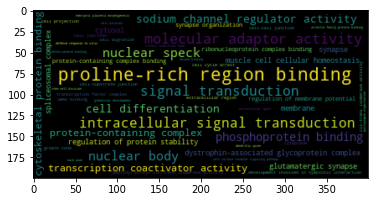

In [14]:
### REQUIRES
GO_ONTOLOGY_PATH = 'data/go/go.json.gz'
TARGET_PATH = 'data/go/go.csv' # Dataset of all human protein with primal key (uniprot_id, go_id)
BACKGROUND_PATH = 'data/go/go_original.csv' #Dataset of 'original' proteins with primal key (uniprot_id, go_id)

### Params
col_name_go_id = 'go_id'
col_name_descr = 'go_descr'
max_pvalue = 0.05
max_depth = 4

### Pipeline
results, word_cloud_img = enrichment_pipeline(GO_ONTOLOGY_PATH=GO_ONTOLOGY_PATH, 
                                              TARGET_PATH=TARGET_PATH, 
                                              BACKGROUND_PATH=BACKGROUND_PATH, 
                                              max_pvalue=max_pvalue,
                                              max_depth=max_depth)

### Display results
fig = plt.imshow(word_cloud_img, interpolation='bilinear')
results.sort_values(by='score').head()

#### 5.3) Enrichment: Original with PDB + other with same PDB vs Huamn with PDB

Fisher Test      : 100%|████████████████████████████████████████| 313/313 [00:01<00:00, 164.99it/s] 
Depth            : 100%|████████████████████████████████████████| 44650/44650 [00:00<00:00, 46429.16
Propagate p-value: 100%|████████████████████████████████████████| 313/313 [00:00<00:00, 502.83it/s] 


,OddRatio,p-value,depth,go_descr,score
0009880,25.886203,0.040779,3,embryonic pattern specification,3.199587
0007596,6.482405,0.039978,3,blood coagulation,3.219435
0050662,37.392202,0.029300,3,coenzyme binding,3.530161
0048037,24.037025,0.029300,2,cofactor binding,3.530161
0005543,5.339777,0.026409,3,phospholipid binding,3.634045


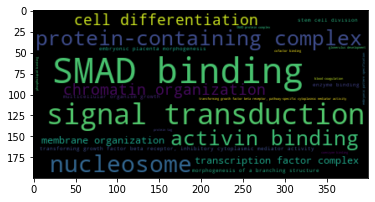

In [15]:
### REQUIRES
GO_ONTOLOGY_PATH = 'data/go/go.json.gz'
TARGET_PATH = 'data/pdb_data/pdb_target_go.csv' 
BACKGROUND_PATH = 'data/pdb_data/pdb_background_go.csv'

### Params
col_name_go_id = 'go_id'
col_name_descr = 'go_descr'
max_pvalue = 0.05
max_depth = 4

### Pipeline
results, word_cloud_img = enrichment_pipeline(GO_ONTOLOGY_PATH=GO_ONTOLOGY_PATH, 
                                              TARGET_PATH=TARGET_PATH, 
                                              BACKGROUND_PATH=BACKGROUND_PATH, 
                                              max_pvalue=max_pvalue,
                                              max_depth=max_depth)

### Display results
fig = plt.imshow(word_cloud_img, interpolation='bilinear')
results.sort_values(by='score').head()

#### 5.4) Enrichment: One specific architecture vs All architecture

Fisher Test      : 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 370.57it/s]   
Depth            : 100%|████████████████████████████████████████| 44650/44650 [00:01<00:00, 40457.23
Propagate p-value: 100%|████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]  


,OddRatio,p-value,depth,go_descr,score
0005096,27.111111,0.049593,4,GTPase activator activity,3.003900
0043087,36.185185,0.039855,5,regulation of GTPase activity,3.222495
0043312,108.777778,0.020110,4,neutrophil degranulation,3.906533
0005576,108.777778,0.020110,2,extracellular region,3.906533


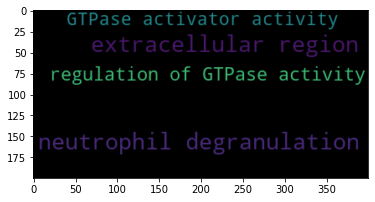

In [17]:
### REQUIRES
GO_ONTOLOGY_PATH = 'data/go/go.json.gz'
TARGET_PATH = 'data/architecture2/go_architectures/PF00018;PF00169;PF00620_arch.csv' 
BACKGROUND_PATH = 'data/architecture2/go_architectures/architecture_background.csv'

### Params
col_name_go_id = 'go_id'
col_name_descr = 'go_descr'
max_pvalue = 0.05
max_depth = 6

### Pipeline
results, word_cloud_img = enrichment_pipeline(GO_ONTOLOGY_PATH=GO_ONTOLOGY_PATH, 
                                              TARGET_PATH=TARGET_PATH, 
                                              BACKGROUND_PATH=BACKGROUND_PATH, 
                                              max_pvalue=max_pvalue,
                                              max_depth=max_depth)

### Display results
fig = plt.imshow(word_cloud_img, interpolation='bilinear')
results.sort_values(by='score').head()